In [1]:
import pandas as pd
import numpy as np
import torch, torch.nn
from transformers import BertModel, BertTokenizer, pipeline
import re, gc, os
import requests
from tqdm.auto import tqdm
import __init__

/z/home/sgal/miniconda3/envs/thermoPML/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.BERTembeddings import BERTembeddings
from src.utilities import train_test_validation_splits, prepare_train_test_val_seqs_by_batches, tensor2dataloader
from src.NeuralArchitectures import regressionHead
from src.Trainer import Trainer


path_meltome = '../datasets/FLIP/splits/meltome/splits/mixed_split.csv'
dir_pre_generated_embeddings = '../prepro_embeddings/'

path_train= dir_pre_generated_embeddings+'train_set_embeddings_ProtBERT.pth'
path_test= dir_pre_generated_embeddings+'test_set_embeddings_ProtBERT.pth'
path_val= dir_pre_generated_embeddings+'val_set_embeddings_ProtBERT.pth'


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

BERT = BERTembeddings(type_embedding = "Rostlab/prot_bert", device = device)
Trainer = Trainer()

splits_meltome = pd.read_csv(path_meltome, sep=',')
split_meltome = splits_meltome[splits_meltome['sequence'].str.len()>= 50]
splits_meltome['sequence']=splits_meltome['sequence'].str.join(" ")
train, val, test = train_test_validation_splits(splits_meltome)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
if os.path.isfile(path_train)==False and os.path.isfile(path_test)==False and os.path.isfile(path_val)==False:

    batch_train, batch_test, batch_val = prepare_train_test_val_seqs_by_batches(train.sequence.to_list(), 
                                                                                test.sequence.to_list(), 
                                                                                val.sequence.to_list(), 
                                                                                batch_size=16)
    print ("Creating Embeddings...")   
    train_embeddings = BERT.embed_dataset(batch_train)
    torch.save(train_embeddings, path_train)
    test_embeddings = BERT.embed_dataset(batch_test)
    torch.save(test_embeddings, path_test)
    val_embeddings = BERT.embed_dataset(batch_val)
    torch.save(val_embeddings, path_val)
    print ("Loaded")
else:
    print ("Loading Premade Embeddings...")
    train_embeddings = torch.load(path_train)
    test_embeddings = torch.load(path_test)
    val_embeddings = torch.load(path_val)
    print ("Loaded")
    
train_loader = tensor2dataloader(train_embeddings, torch.from_numpy( train.target.to_numpy() ), batch_size=50)
test_loader = tensor2dataloader(test_embeddings, torch.from_numpy( test.target.to_numpy() ), batch_size=50)
val_loader = tensor2dataloader(val_embeddings, torch.from_numpy( val.target.to_numpy() ), batch_size=50)

Loading Premade Embeddings...


Loaded


In [4]:
model = regressionHead(train_embeddings.shape[1::])
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss= torch.nn.MSELoss()
epochs = 200
model, val_loss = Trainer.train_LLMRegresor(train_loader, val_loader, model, device, loss, opt, epochs)

epoch: 1 loss: 909.356 val loss: 1068.380


epoch: 2 loss: 260.468 val loss: 452.294


epoch: 3 loss: 120.062 val loss: 206.714


epoch: 4 loss: 164.562 val loss: 130.701


epoch: 5 loss: 67.178 val loss: 114.421


epoch: 6 loss: 76.908 val loss: 112.644


epoch: 7 loss: 87.676 val loss: 112.807


epoch: 8 loss: 128.535 val loss: 113.070


epoch: 9 loss: 67.487 val loss: 112.932


epoch: 10 loss: 112.203 val loss: 112.856


epoch: 11 loss: 66.376 val loss: 112.823


epoch: 12 loss: 124.031 val loss: 110.457


epoch: 13 loss: 91.984 val loss: 96.215


epoch: 14 loss: 59.031 val loss: 83.526


epoch: 15 loss: 46.357 val loss: 72.881


epoch: 16 loss: 64.064 val loss: 64.044


epoch: 17 loss: 52.378 val loss: 57.911


epoch: 18 loss: 39.937 val loss: 53.709


epoch: 19 loss: 49.695 val loss: 51.182


epoch: 20 loss: 59.860 val loss: 49.110


epoch: 21 loss: 29.537 val loss: 48.149


epoch: 22 loss: 46.370 val loss: 47.585


epoch: 23 loss: 18.106 val loss: 46.440


epoch: 24 loss: 37.897 val loss: 45.984


epoch: 25 loss: 29.638 val loss: 45.441


epoch: 26 loss: 55.716 val loss: 45.000


epoch: 27 loss: 25.996 val loss: 44.964


epoch: 28 loss: 43.918 val loss: 44.434


epoch: 29 loss: 45.426 val loss: 44.413


epoch: 30 loss: 63.080 val loss: 45.277


epoch: 31 loss: 42.182 val loss: 43.861


epoch: 32 loss: 84.429 val loss: 43.578


epoch: 33 loss: 47.007 val loss: 44.213


epoch: 34 loss: 27.854 val loss: 43.891


epoch: 35 loss: 60.546 val loss: 43.377


epoch: 36 loss: 25.839 val loss: 43.598


epoch: 37 loss: 52.281 val loss: 42.537


epoch: 38 loss: 43.197 val loss: 43.181


epoch: 39 loss: 60.192 val loss: 42.636


epoch: 40 loss: 55.031 val loss: 42.166


epoch: 41 loss: 54.888 val loss: 42.412


epoch: 42 loss: 41.308 val loss: 41.988


epoch: 43 loss: 61.918 val loss: 42.493


epoch: 44 loss: 29.693 val loss: 41.731


epoch: 45 loss: 51.254 val loss: 42.394


epoch: 46 loss: 39.450 val loss: 41.748


epoch: 47 loss: 44.494 val loss: 42.408


epoch: 48 loss: 20.936 val loss: 41.306


epoch: 49 loss: 28.634 val loss: 41.179


epoch: 50 loss: 34.999 val loss: 41.246


epoch: 51 loss: 42.667 val loss: 40.923


epoch: 52 loss: 26.171 val loss: 41.629


epoch: 53 loss: 48.144 val loss: 41.432


epoch: 54 loss: 27.906 val loss: 40.723


epoch: 55 loss: 64.798 val loss: 40.950


epoch: 56 loss: 23.423 val loss: 40.705


epoch: 57 loss: 35.199 val loss: 40.655


epoch: 58 loss: 33.959 val loss: 40.626


epoch: 59 loss: 25.987 val loss: 40.422


epoch: 60 loss: 35.631 val loss: 40.257


epoch: 61 loss: 31.161 val loss: 40.264


epoch: 62 loss: 55.644 val loss: 40.966


epoch: 63 loss: 56.574 val loss: 40.361


epoch: 64 loss: 12.877 val loss: 40.051


epoch: 65 loss: 25.150 val loss: 40.476


epoch: 66 loss: 22.972 val loss: 40.141


epoch: 67 loss: 38.959 val loss: 40.150


epoch: 68 loss: 30.935 val loss: 39.919


epoch: 69 loss: 55.911 val loss: 40.259


epoch: 70 loss: 34.855 val loss: 40.239


epoch: 71 loss: 41.825 val loss: 39.929


epoch: 72 loss: 26.066 val loss: 40.225


epoch: 73 loss: 26.720 val loss: 39.573


epoch: 74 loss: 51.280 val loss: 39.545


epoch: 75 loss: 22.409 val loss: 40.071


epoch: 76 loss: 32.485 val loss: 39.483


epoch: 77 loss: 31.489 val loss: 39.595


epoch: 78 loss: 27.069 val loss: 40.189


epoch: 79 loss: 47.962 val loss: 39.429


epoch: 80 loss: 26.568 val loss: 39.304


epoch: 81 loss: 29.125 val loss: 39.254


epoch: 82 loss: 51.660 val loss: 39.304


epoch: 83 loss: 29.304 val loss: 39.245


epoch: 84 loss: 50.153 val loss: 39.237


epoch: 85 loss: 31.390 val loss: 39.268


epoch: 86 loss: 32.675 val loss: 39.110


epoch: 87 loss: 31.286 val loss: 39.137


epoch: 88 loss: 27.306 val loss: 38.930


epoch: 89 loss: 40.310 val loss: 38.980


epoch: 90 loss: 32.361 val loss: 39.031


epoch: 91 loss: 37.552 val loss: 39.289


epoch: 92 loss: 57.568 val loss: 38.932


epoch: 93 loss: 41.171 val loss: 38.743


epoch: 94 loss: 26.513 val loss: 39.013


epoch: 95 loss: 20.226 val loss: 38.684


epoch: 96 loss: 18.276 val loss: 39.540


epoch: 97 loss: 25.485 val loss: 38.647


epoch: 98 loss: 46.019 val loss: 38.635


epoch: 99 loss: 28.710 val loss: 38.975


epoch: 100 loss: 30.991 val loss: 38.422


epoch: 101 loss: 52.440 val loss: 38.309


epoch: 102 loss: 23.107 val loss: 38.842


epoch: 103 loss: 22.379 val loss: 39.030


epoch: 104 loss: 27.872 val loss: 39.026


epoch: 105 loss: 36.021 val loss: 38.999


epoch: 106 loss: 26.610 val loss: 38.288


epoch: 107 loss: 32.842 val loss: 38.827


epoch: 108 loss: 71.983 val loss: 38.411


epoch: 109 loss: 18.388 val loss: 37.955


epoch: 110 loss: 23.246 val loss: 38.400


epoch: 111 loss: 32.551 val loss: 37.946


epoch: 112 loss: 19.596 val loss: 37.915


epoch: 113 loss: 37.925 val loss: 37.840


epoch: 114 loss: 30.483 val loss: 37.711


epoch: 115 loss: 32.029 val loss: 38.369


epoch: 116 loss: 37.616 val loss: 37.775


epoch: 117 loss: 19.528 val loss: 37.710


epoch: 118 loss: 23.025 val loss: 37.954


epoch: 119 loss: 21.141 val loss: 38.017


epoch: 120 loss: 29.075 val loss: 37.951


epoch: 121 loss: 27.193 val loss: 37.581


epoch: 122 loss: 18.784 val loss: 37.692


epoch: 123 loss: 24.574 val loss: 37.750


epoch: 124 loss: 24.034 val loss: 37.417


epoch: 125 loss: 25.484 val loss: 37.564


epoch: 126 loss: 39.075 val loss: 37.952


epoch: 127 loss: 17.942 val loss: 37.551


epoch: 128 loss: 22.434 val loss: 37.469


epoch: 129 loss: 46.155 val loss: 37.418


epoch: 130 loss: 36.972 val loss: 37.339


epoch: 131 loss: 15.997 val loss: 37.611


epoch: 132 loss: 38.436 val loss: 37.514


epoch: 133 loss: 37.056 val loss: 37.330


epoch: 134 loss: 34.960 val loss: 37.114


epoch: 135 loss: 35.595 val loss: 37.597


epoch: 136 loss: 31.323 val loss: 37.073


epoch: 137 loss: 41.151 val loss: 37.556


epoch: 138 loss: 23.790 val loss: 37.717


epoch: 139 loss: 28.342 val loss: 37.187


epoch: 140 loss: 16.702 val loss: 38.520


epoch: 141 loss: 15.925 val loss: 36.991


epoch: 142 loss: 31.946 val loss: 37.369


epoch: 143 loss: 34.629 val loss: 37.251


epoch: 144 loss: 31.480 val loss: 37.143


epoch: 145 loss: 18.982 val loss: 36.966


epoch: 146 loss: 25.756 val loss: 37.381


epoch: 147 loss: 31.664 val loss: 36.950


epoch: 148 loss: 51.250 val loss: 36.908


epoch: 149 loss: 39.354 val loss: 36.810


epoch: 150 loss: 41.762 val loss: 36.955


epoch: 151 loss: 63.332 val loss: 37.413


epoch: 152 loss: 34.754 val loss: 37.111


epoch: 153 loss: 24.441 val loss: 36.642


epoch: 154 loss: 23.529 val loss: 36.883


epoch: 155 loss: 18.733 val loss: 37.182


epoch: 156 loss: 31.878 val loss: 37.318


epoch: 157 loss: 16.106 val loss: 36.711


epoch: 158 loss: 26.216 val loss: 37.013


epoch: 159 loss: 26.798 val loss: 36.893


epoch: 160 loss: 27.668 val loss: 37.377


epoch: 161 loss: 27.861 val loss: 36.649


epoch: 162 loss: 33.160 val loss: 36.500


epoch: 163 loss: 45.982 val loss: 36.791


epoch: 164 loss: 20.015 val loss: 36.490


epoch: 165 loss: 47.301 val loss: 37.403


epoch: 166 loss: 24.811 val loss: 36.525


epoch: 167 loss: 44.926 val loss: 36.603


epoch: 168 loss: 33.230 val loss: 36.446


epoch: 169 loss: 60.417 val loss: 36.517


epoch: 170 loss: 24.050 val loss: 36.312


epoch: 171 loss: 26.341 val loss: 37.092


epoch: 172 loss: 47.309 val loss: 38.350


epoch: 173 loss: 17.279 val loss: 36.338


epoch: 174 loss: 39.516 val loss: 36.630


epoch: 175 loss: 17.758 val loss: 36.676


epoch: 176 loss: 27.048 val loss: 36.533


epoch: 177 loss: 23.612 val loss: 36.320


epoch: 178 loss: 26.154 val loss: 36.954


epoch: 179 loss: 23.350 val loss: 36.111


epoch: 180 loss: 21.619 val loss: 36.695


epoch: 181 loss: 46.193 val loss: 36.289


epoch: 182 loss: 26.235 val loss: 37.136


epoch: 183 loss: 25.931 val loss: 36.699


epoch: 184 loss: 45.549 val loss: 36.981


epoch: 185 loss: 29.445 val loss: 36.346


epoch: 186 loss: 33.771 val loss: 36.140


epoch: 187 loss: 23.680 val loss: 36.104


epoch: 188 loss: 26.502 val loss: 36.457


epoch: 189 loss: 21.637 val loss: 36.318


epoch: 190 loss: 33.237 val loss: 37.236


epoch: 191 loss: 44.531 val loss: 36.971


epoch: 192 loss: 43.850 val loss: 36.025


epoch: 193 loss: 22.094 val loss: 36.362


epoch: 194 loss: 49.167 val loss: 36.039


epoch: 195 loss: 28.783 val loss: 36.166


epoch: 196 loss: 31.565 val loss: 36.841


epoch: 197 loss: 23.168 val loss: 36.824


epoch: 198 loss: 32.007 val loss: 36.226


epoch: 199 loss: 31.508 val loss: 36.089


epoch: 200 loss: 29.715 val loss: 36.065


MSE: tensor(37.9129, device='cuda:0', grad_fn=<MseLossBackward0>)
RMSE: tensor(6.1573, device='cuda:0', grad_fn=<SqrtBackward0>)
MAE: tensor(2.1311, device='cuda:0', grad_fn=<SqrtBackward0>)


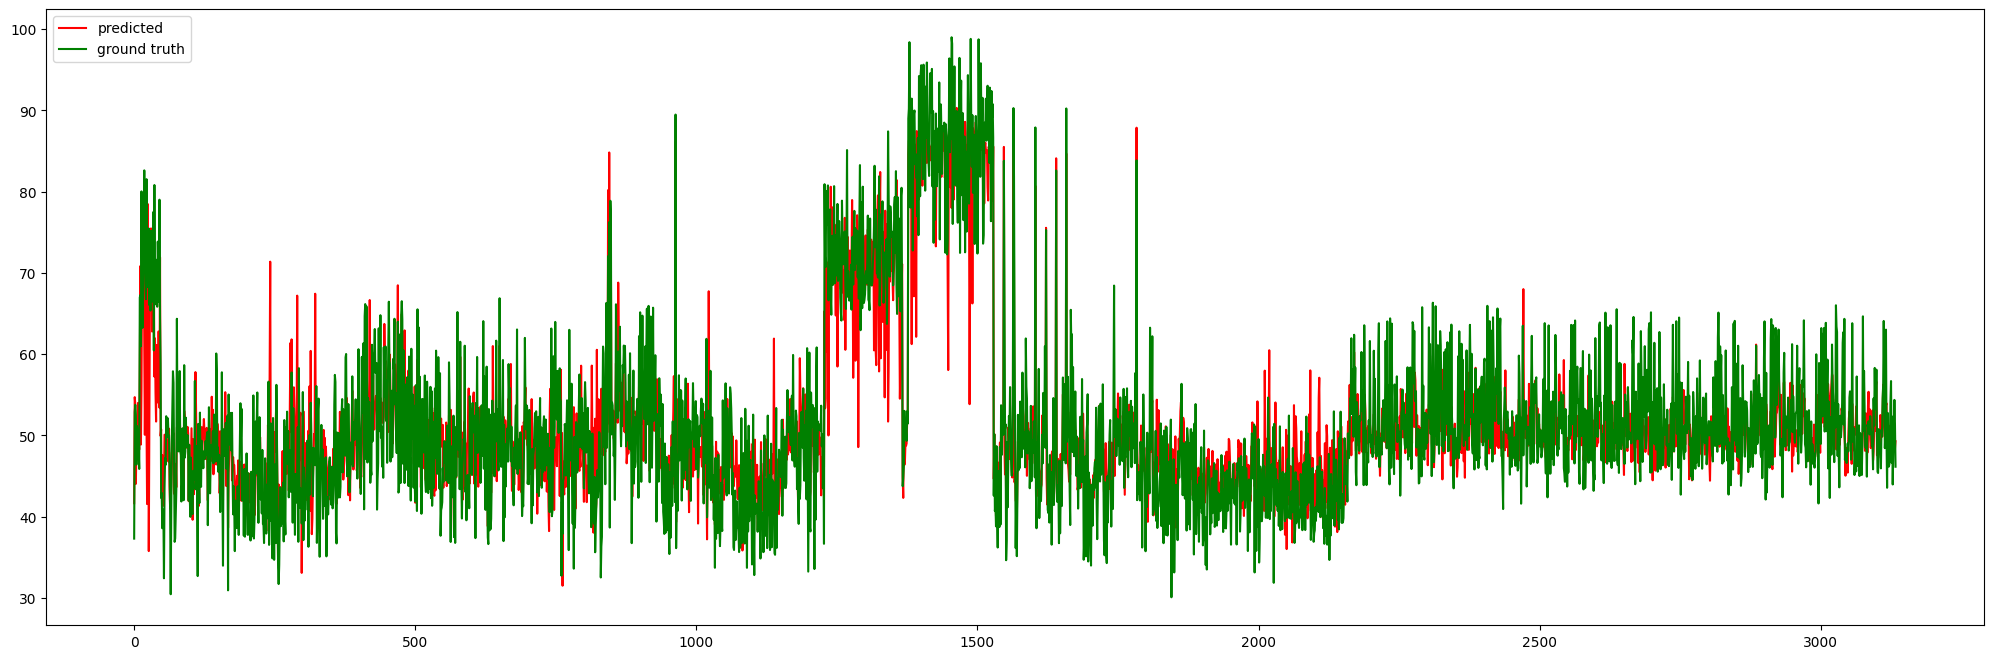

In [5]:
test_set, test_labels = test_loader.dataset.tensors
loss_test, outcome = Trainer.test_model(model, test_set, test_labels, loss, device)
from src.utilities import plot_results

plot_results( outcome, test_labels) 